In [785]:
import matplotlib.pyplot as plt
import numpy as np


In [8]:
def f(x):
    return 3*x**2 + 4*x - 5

In [14]:
f(4)

59

In [42]:
x_axis = np.arange(-4,4,1)
x_axis

array([-4, -3, -2, -1,  0,  1,  2,  3])

In [46]:
y_axis = f(x_axis)
y_axis

array([27, 10, -1, -6, -5,  2, 15, 34])

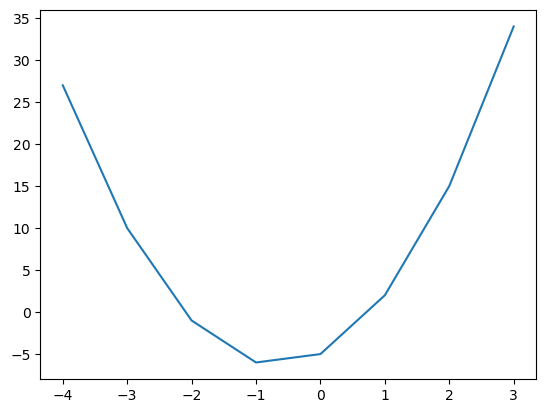

In [52]:
plt.plot(x_axis,y_axis)

In [1281]:
#Digraph
def trace(root):
    nodes , edges = set(),set();
    def build(v):
        nodes.add(v)
        for child in v._prev:
            edges.add((child,v))
            build(child)
    build(root);
    return nodes , edges



In [1280]:
!pip install graphviz
from graphviz import Digraph
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes , edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f }"%(n.label,n.data,n.grad))
        if n._op:
            dot.node(name = uid+n._op,label = n._op)
            dot.edge(uid+n._op,uid)#op to node it was in
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

In [3555]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data;
        self._backward = lambda: None
        self.grad = 0;
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward;
        return out
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += out.grad;
            other.grad += out.grad;
        out._backward = _backward;
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def _tanh(self):
        x = np.exp(self.data*2)
        out = Value(((x - 1) /(x+1)),(self,),'tanh')
        def _backward():
            self.grad = (1 - (out.data)**2 ) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for dot in reversed(topo):
            dot._backward()
        
            
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value({self.label},data={self.data}, grad={self.grad})"        

In [3557]:
x1 = Value(2,label='x1');x2 = Value(-1,label='x2')
w1 = Value(3,label='w1');w2 = Value(4,label='w2')
b = Value(-4,label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2;
x1w1x2w2.label = 'x1w1x2w2'
l = x1w1x2w2 + b
l.label ='L'
out = l._tanh();
out.label = 'o'
out.backward()

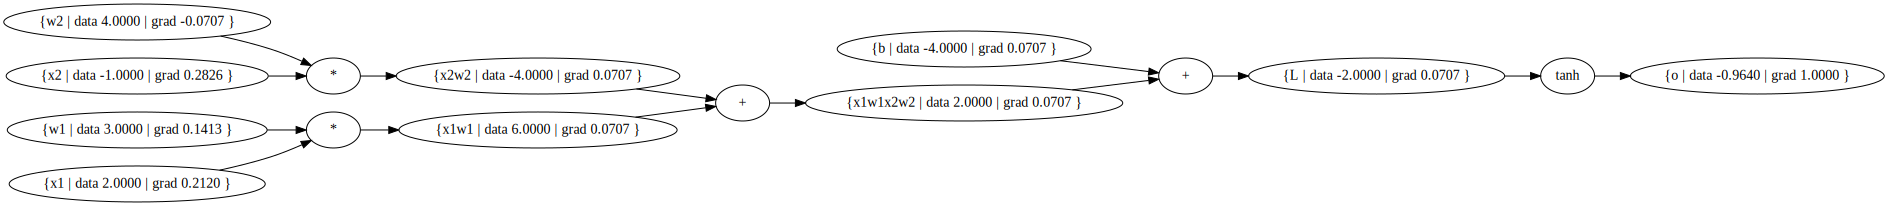

In [906]:
draw_dot(out)

In [3577]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def parameters(self):
        return self.w + [self.b]
    
    def __call__(self,x):
         act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
         out = act._tanh()
         return out
             
class Layer():
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def parameters(self):
        return [param for neurons in self.neurons for param in neurons.parameters()]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # smart way as the previous number of outputs from layer will become the number of inputs for next
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __call__(self,x):
        for layer in self.layers: #smart way of passing the output of first layer as input to the next layer.
            x = layer(x)
        return x

In [3591]:
k = MLP(3,[4,4,1])
k_weight = k.parameters()

In [3599]:
xs = [[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0] #target
def temp():    
    for i in range(1000):
       # forward pass
        ypred = [k(x) for x in xs]
        loss = sum((yout-ygt)**2 for yout,ygt in zip(ys,ypred))
        for p in k.parameters():
            p.grad = 0;
        loss.backward()
        #update
        for param in k.parameters():
            param.data += -0.02*param.grad
        print(i,loss.data,ypred)  

In [3601]:
temp()


0 0.003035174400977287 [Value(,data=0.9788735777867388, grad=-0.04225284442652244), Value(,data=-0.9856594315256977, grad=0.028681136948604635), Value(,data=-0.9633061945530864, grad=0.07338761089382717), Value(,data=0.9678012201612823, grad=-0.06439755967743532)]
1 0.0030295389536718472 [Value(,data=0.9788930954105755, grad=-0.04221380917884909), Value(,data=-0.9856719226299107, grad=0.028656154740178685), Value(,data=-0.9633401503242028, grad=0.07331969935159433), Value(,data=0.9678317057811661, grad=-0.06433658843766787)]
2 0.0030239240018988182 [Value(,data=0.9789125600574583, grad=-0.042174879885083394), Value(,data=-0.9856843811668659, grad=0.028631237666268294), Value(,data=-0.9633740141147301, grad=0.07325197177053977), Value(,data=0.9678621081288, grad=-0.06427578374239995)]
3 0.0030183294349168804 [Value(,data=0.9789319719651434, grad=-0.04213605606971327), Value(,data=-0.9856968072780926, grad=0.028606385443814775), Value(,data=-0.963407786336276, grad=0.07318442732744801), 

[Value(,data=0.8970381343639302, grad=1),
 Value(,data=0.9398176581482561, grad=1),
 Value(,data=0.8836380435647337, grad=1),
 Value(,data=0.864560774661568, grad=1)]